In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/Google_Historical_StockPrice2.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [3]:
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,736.789978,738.989990,732.500000,733.530029,733.530029,1301300
1,2016-03-29,734.590027,747.250000,728.760010,744.770020,744.770020,1903800
2,2016-03-30,750.099976,757.880005,748.739990,750.530029,750.530029,1782400
3,2016-03-31,749.250000,750.849976,740.940002,744.950012,744.950012,1718800
4,2016-04-01,738.599976,750.340027,737.000000,749.909973,749.909973,1576700
5,2016-04-04,750.059998,752.799988,742.429993,745.289978,745.289978,1134200
6,2016-04-05,738.000000,742.799988,735.369995,737.799988,737.799988,1132300
7,2016-04-06,735.770020,746.239990,735.559998,745.690002,745.690002,1053700
8,2016-04-07,745.369995,747.000000,736.280029,740.280029,740.280029,1453200
9,2016-04-08,743.969971,745.450012,735.549988,739.150024,739.150024,1290800


In [4]:
data = data[["Date", "Close"]]
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d")
data["Date"] = data["Date"].apply(lambda dt: dt.strftime("%Y-%m"))

# I suppose, "close" price is the last time of the period
data = pd.DataFrame(data.groupby("Date")["Close"].last())
data.sort_index(inplace=True)
data.head(14)

,Close
Date,
2016-03,744.950012
2016-04,693.010010
2016-05,735.719971
2016-06,692.099976
2016-07,768.789978
2016-08,767.049988
2016-09,777.289978
2016-10,784.539978
2016-11,758.039978


Оставим по одной записи на неделю

In [5]:
print("from: ", data.first_valid_index())
print("to: ", data.last_valid_index())

from:  2016-03
to:  2021-03


## Посмотрим на графики

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

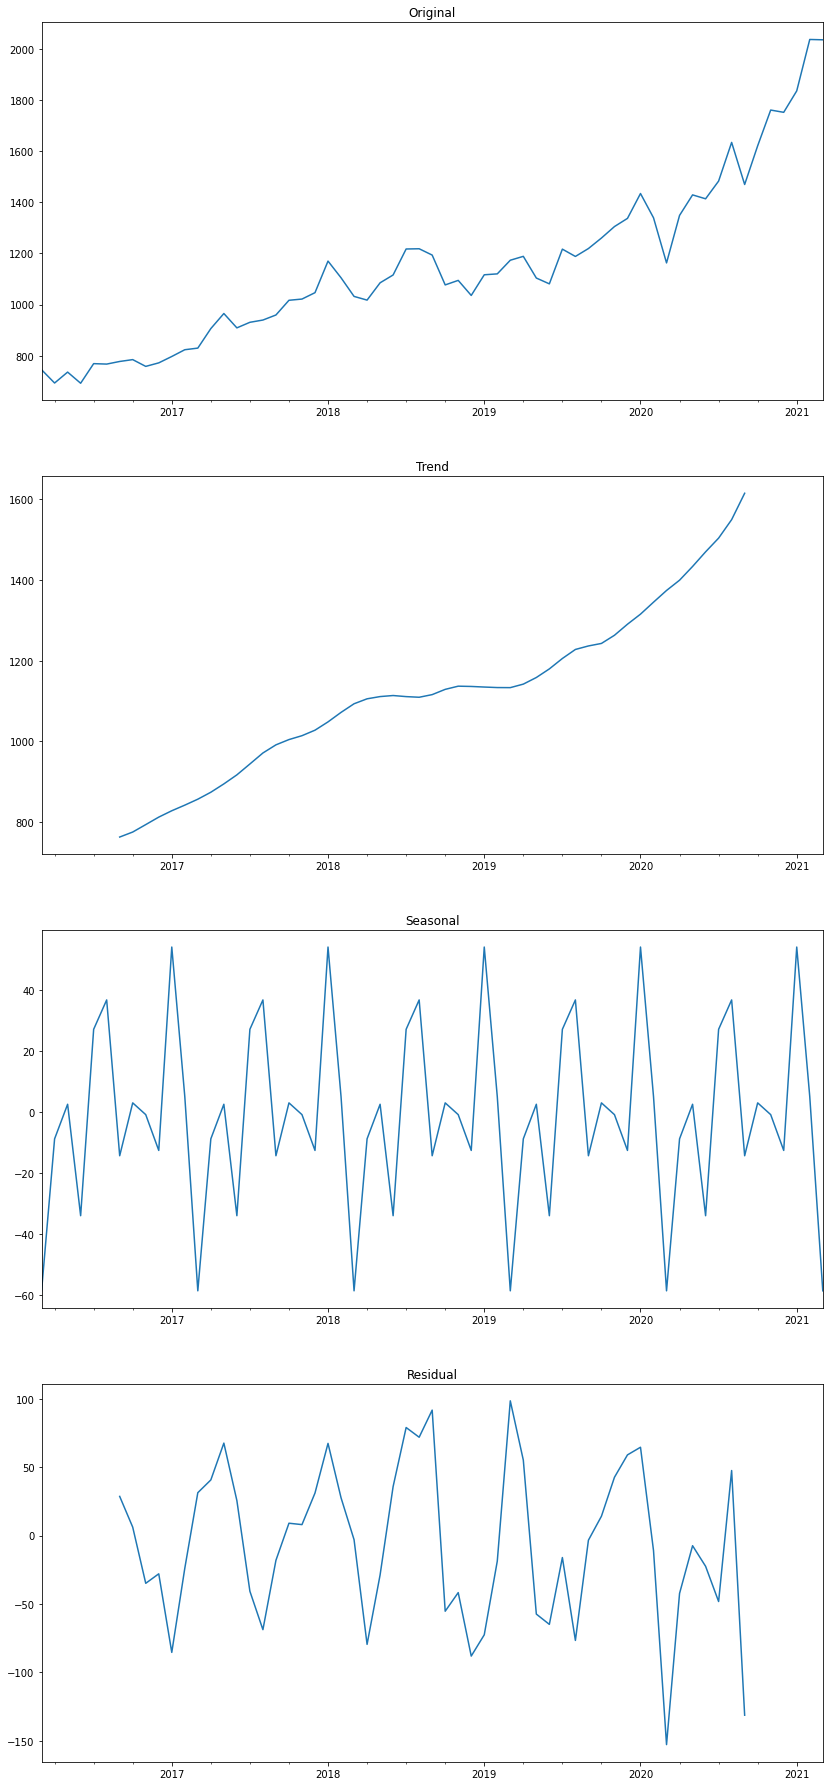

In [33]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 32))
decompose = seasonal_decompose(data["Close"], period=12)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

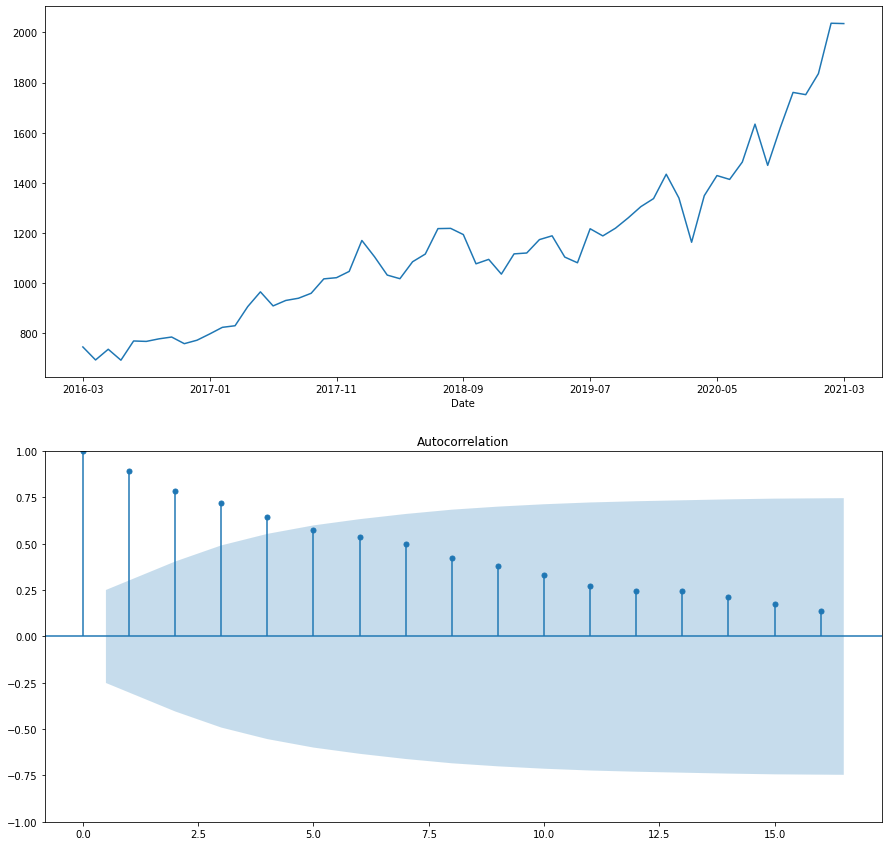

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
data["Close"].plot(ax=ax[0])
plot_acf(data["Close"], lags=16, ax=ax[1]);

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
p_value = adfuller(data["Close"])[1]
p_value = round(p_value, 4)
print("p-value {} is greater than 0.05".format(p_value))

p-value 0.9987 is greater than 0.05


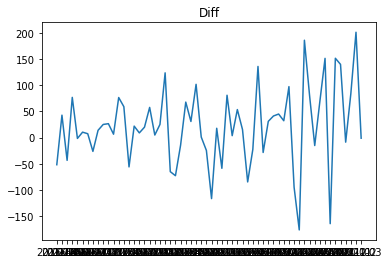

In [11]:
plt.plot((data["Close"] - data["Close"].shift(1))[1:])
plt.title("Diff")
plt.show()

Дисперсия увеличивается со временем, всё ещё не стационарный ряд

In [12]:
import numpy as np

In [13]:
logged = np.log(data["Close"])
log_diff = logged - logged.shift(1)

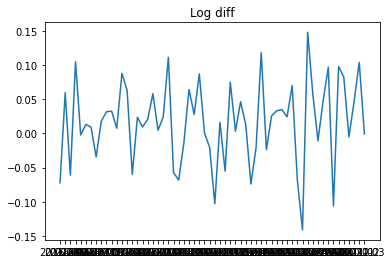

In [14]:
plt.plot(log_diff[1:])
plt.title("Log diff")
plt.show()

In [15]:
p_value = adfuller(log_diff[1:])[1]
p_value = round(p_value, 4)
print("p-value {} is less than 0.05".format(p_value))

p-value 0.0215 is less than 0.05


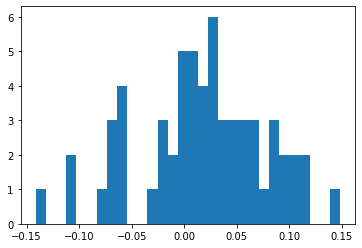

In [16]:
_ = plt.hist(log_diff, bins=30)

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

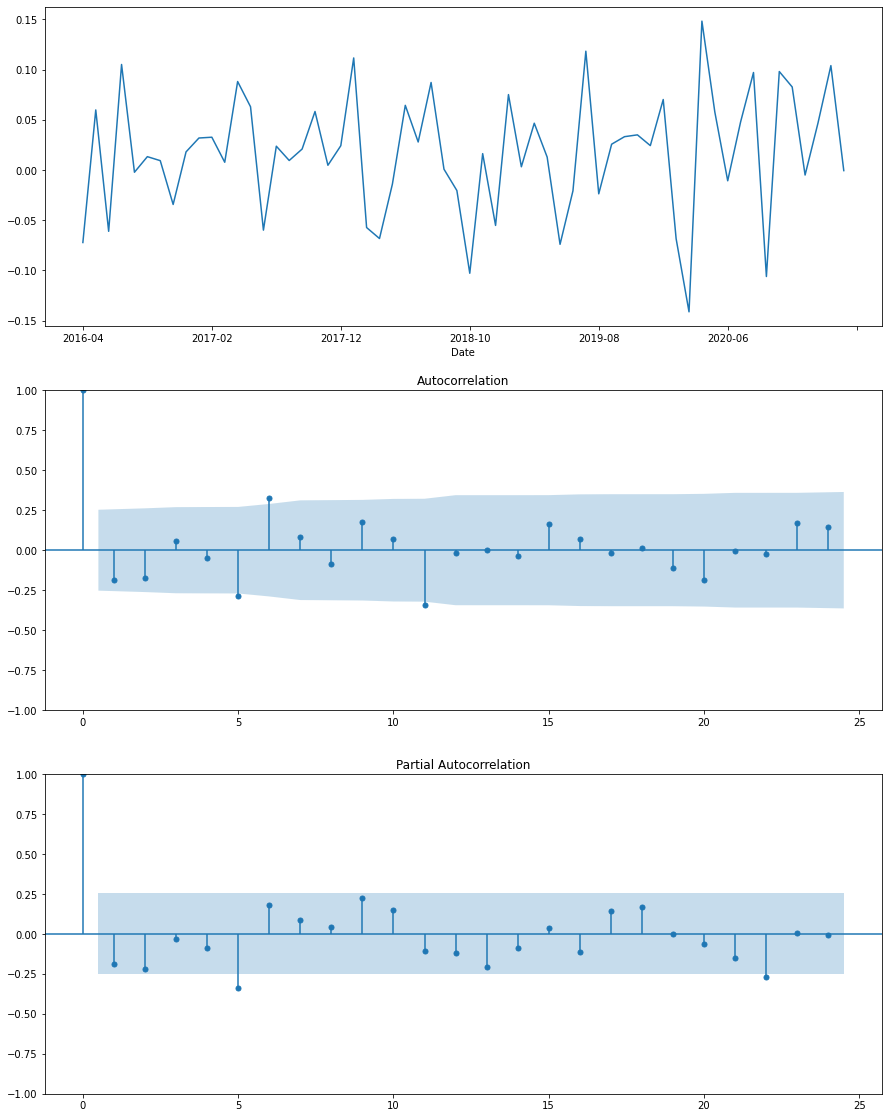

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
log_diff[1:].plot(ax=ax[0])
plot_acf(log_diff[1:], lags=24, ax=ax[1]);
plot_pacf(log_diff[1:], lags=24, ax=ax[2], method='ywm');

In [19]:
d = 1
D = 1

qs = range(1, 7)
Qs = range(1, 4)

ps = range(1, 7)
Ps = range(3, 7)

In [20]:
from itertools import product

In [21]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

432

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [23]:
data["CloseLog"] = logged
data.index = pd.DatetimeIndex(data.index.values, freq="infer")
data.head(14)

,Close,CloseLog
2016-03-01,744.950012,6.613317
2016-04-01,693.010010,6.541044
2016-05-01,735.719971,6.600850
2016-06-01,692.099976,6.539730
2016-07-01,768.789978,6.644818
2016-08-01,767.049988,6.642552
2016-09-01,777.289978,6.655813
2016-10-01,784.539978,6.665098
2016-11-01,758.039978,6.630736
2016-12-01,771.820007,6.648751


In [24]:
print(data.shape)

test_part = int(0.2 * data.shape[0])
train_part = data.shape[0] - test_part

data_train = data[:train_part]
data_test = data[-test_part:]

print(data_train.shape)
print(data_test.shape)

(61, 2)
(49, 2)
(12, 2)


In [25]:
#warnings.filterwarnings('ignore')

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = SARIMAX(
            data_train["CloseLog"],
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 6)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

#warnings.filterwarnings('default')

  0%|          | 0/432 [00:00<?, ?it/s]/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
  0%|          | 1/432 [00:00<05:15,  1.37it/s]/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/pyt

wrong parameters: (1, 6, 3, 1)
wrong parameters: (1, 6, 3, 2)
wrong parameters: (1, 6, 3, 3)
wrong parameters: (1, 6, 4, 1)
wrong parameters: (1, 6, 4, 2)
wrong parameters: (1, 6, 4, 3)
wrong parameters: (1, 6, 5, 1)
wrong parameters: (1, 6, 5, 2)
wrong parameters: (1, 6, 5, 3)
wrong parameters: (1, 6, 6, 1)
wrong parameters: (1, 6, 6, 2)
wrong parameters: (1, 6, 6, 3)


/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 17%|█▋        | 73/432 [01:36<02:40,  2.24it/s]/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: 

wrong parameters: (2, 6, 3, 1)
wrong parameters: (2, 6, 3, 2)
wrong parameters: (2, 6, 3, 3)
wrong parameters: (2, 6, 4, 1)
wrong parameters: (2, 6, 4, 2)
wrong parameters: (2, 6, 4, 3)
wrong parameters: (2, 6, 5, 1)
wrong parameters: (2, 6, 5, 2)
wrong parameters: (2, 6, 5, 3)
wrong parameters: (2, 6, 6, 1)
wrong parameters: (2, 6, 6, 2)
wrong parameters: (2, 6, 6, 3)


/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 34%|███▎      | 145/432 [03:28<02:17,  2.09it/s]/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 34%|███▍      | 146/432 [03:29<02:26,  1.96it/s]/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/t

wrong parameters: (3, 6, 3, 1)
wrong parameters: (3, 6, 3, 2)
wrong parameters: (3, 6, 3, 3)
wrong parameters: (3, 6, 4, 1)
wrong parameters: (3, 6, 4, 2)
wrong parameters: (3, 6, 4, 3)
wrong parameters: (3, 6, 5, 1)
wrong parameters: (3, 6, 5, 2)
wrong parameters: (3, 6, 5, 3)
wrong parameters: (3, 6, 6, 1)
wrong parameters: (3, 6, 6, 2)
wrong parameters: (3, 6, 6, 3)


/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 50%|█████     | 217/432 [05:30<01:55,  1.86it/s]/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 50%|█████     | 218/432 [05:31<02:04,  1.72it/s]/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/t

wrong parameters: (4, 6, 3, 1)
wrong parameters: (4, 6, 3, 2)
wrong parameters: (4, 6, 3, 3)
wrong parameters: (4, 6, 4, 1)
wrong parameters: (4, 6, 4, 2)
wrong parameters: (4, 6, 4, 3)
wrong parameters: (4, 6, 5, 1)
wrong parameters: (4, 6, 5, 2)
wrong parameters: (4, 6, 5, 3)
wrong parameters: (4, 6, 6, 1)
wrong parameters: (4, 6, 6, 2)
wrong parameters: (4, 6, 6, 3)


/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 67%|██████▋   | 289/432 [07:56<01:29,  1.60it/s]/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 67%|██████▋   | 290/432 [07:57<01:35,  1.48it/s]/home/eezotop/.local/share/virtualenvs/lab-3-hrEL6Lop/lib/python3.8/site-packages/statsmodels/t

wrong parameters: (5, 6, 3, 1)
wrong parameters: (5, 6, 3, 2)
wrong parameters: (5, 6, 3, 3)
wrong parameters: (5, 6, 4, 1)
wrong parameters: (5, 6, 4, 2)
wrong parameters: (5, 6, 4, 3)
wrong parameters: (5, 6, 5, 1)
wrong parameters: (5, 6, 5, 2)
wrong parameters: (5, 6, 5, 3)
wrong parameters: (5, 6, 6, 1)
wrong parameters: (5, 6, 6, 2)
wrong parameters: (5, 6, 6, 3)
wrong parameters: (6, 1, 3, 1)
wrong parameters: (6, 1, 3, 2)
wrong parameters: (6, 1, 3, 3)
wrong parameters: (6, 1, 4, 1)
wrong parameters: (6, 1, 4, 2)
wrong parameters: (6, 1, 4, 3)
wrong parameters: (6, 1, 5, 1)
wrong parameters: (6, 1, 5, 2)
wrong parameters: (6, 1, 5, 3)
wrong parameters: (6, 1, 6, 1)
wrong parameters: (6, 1, 6, 2)
wrong parameters: (6, 1, 6, 3)
wrong parameters: (6, 2, 3, 1)
wrong parameters: (6, 2, 3, 2)
wrong parameters: (6, 2, 3, 3)
wrong parameters: (6, 2, 4, 1)
wrong parameters: (6, 2, 4, 2)
wrong parameters: (6, 2, 4, 3)
wrong parameters: (6, 2, 5, 1)
wrong parameters: (6, 2, 5, 2)
wrong pa

In [26]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
216  (4, 4, 3, 1) -116.387611
217  (4, 4, 3, 2) -114.885570
219  (4, 4, 4, 1) -114.425210
276  (5, 4, 3, 1) -113.967985
36   (1, 4, 3, 1) -113.838515


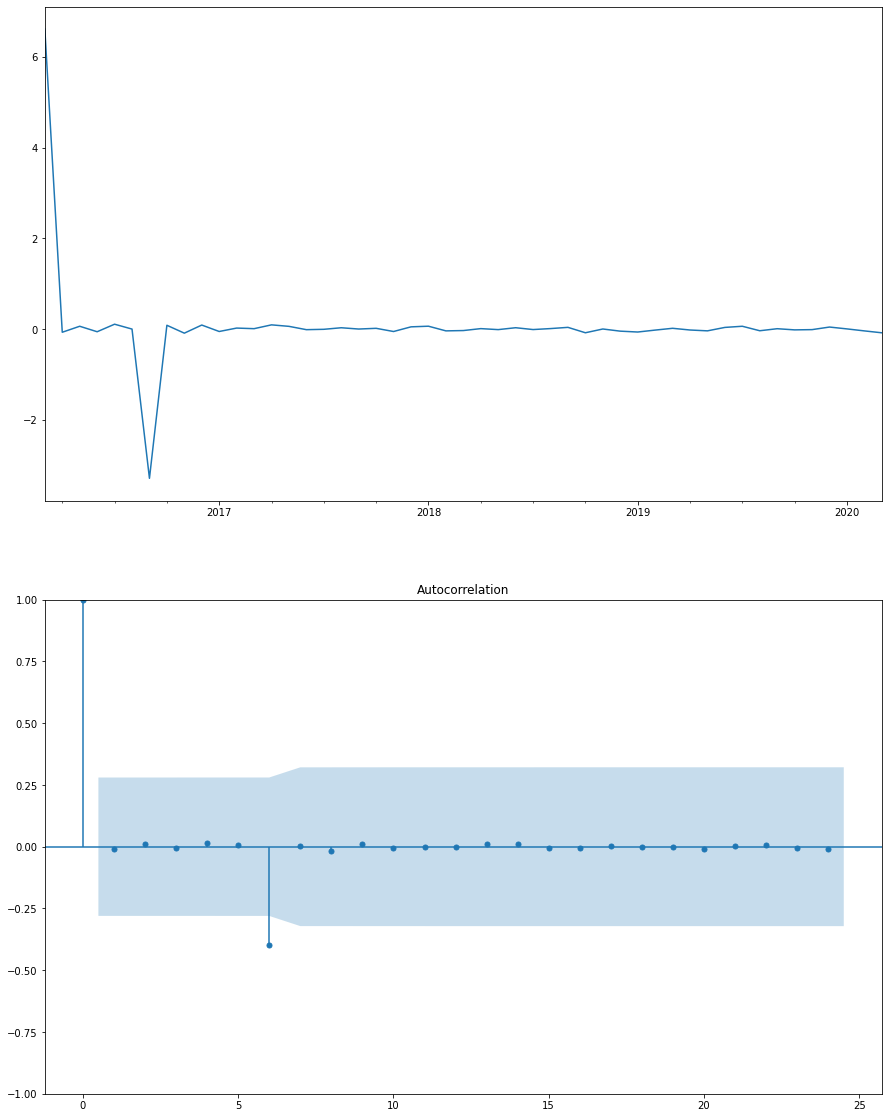

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))
best_model.resid[:train_part].plot(ax=ax[0])
plot_acf(best_model.resid[:train_part].values.squeeze(), lags=24, ax=ax[1]);

<AxesSubplot:>

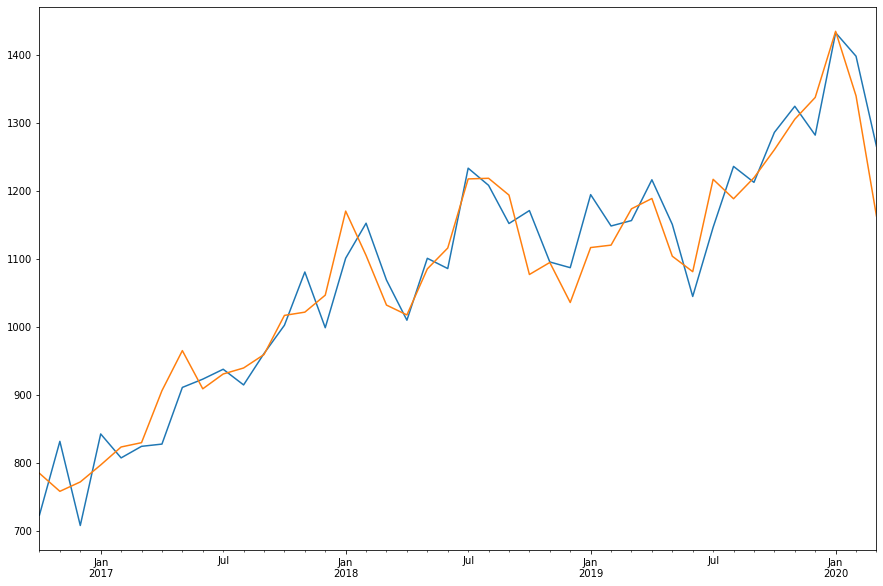

In [28]:
data["Predicted"] = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15, 10))
data["Predicted"][7:train_part].plot()
data["Close"][7:train_part].plot()

<AxesSubplot:>

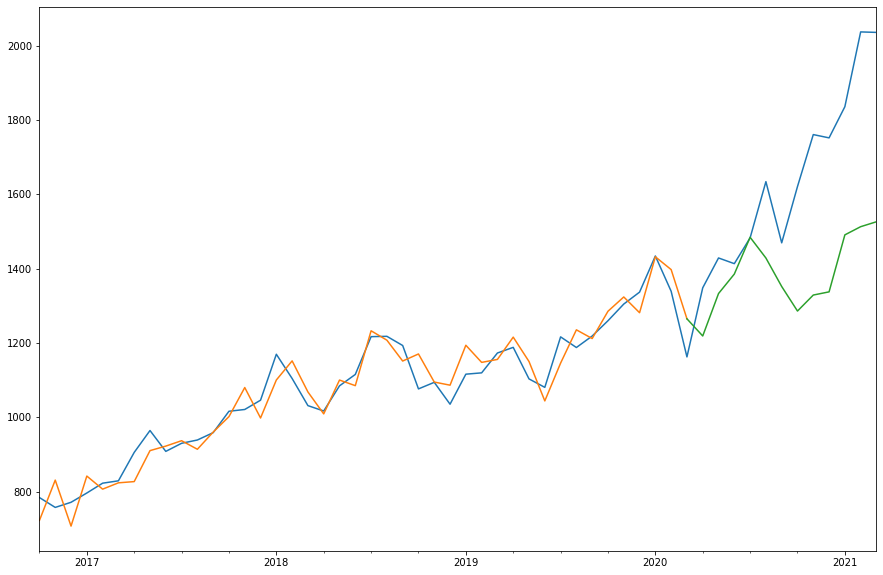

In [29]:
data["Predicted"][train_part:] = np.exp(best_model.predict(start=train_part, end=train_part-1+test_part))

plt.figure(figsize=(15, 10))
data["Close"][7:].plot()
data["Predicted"][7:train_part].plot()
data["Predicted"][train_part-1:].plot()

In [30]:
from sklearn.metrics import mean_absolute_percentage_error

In [31]:
mean_absolute_percentage_error(data["Close"][-test_part:], data["Predicted"][-test_part:]) * 100

14.772656934665637